In [1]:
!git clone https://github.com/dungnq271/TRACER.git

fatal: destination path 'TRACER' already exists and is not an empty directory.


In [2]:
# %cd ..
# !rm -rf TRACER

In [3]:
%cd TRACER

/home/cat/projects/CV-stuff/background_remover/TRACER


/home/cat/.env/pytorch/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
!pip install albumentations

In [5]:
import os
import os.path as osp
import random

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
from tqdm import tqdm
from dataloader import get_test_augmentation, get_loader
from model.TRACER import TRACER
from util.utils import load_pretrained

In [6]:
def get_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

5762
(3840, 2160, 3)
(4032, 3024, 3)
(4032, 3016, 3)
(4032, 3024, 3)
(3077, 3016, 3)


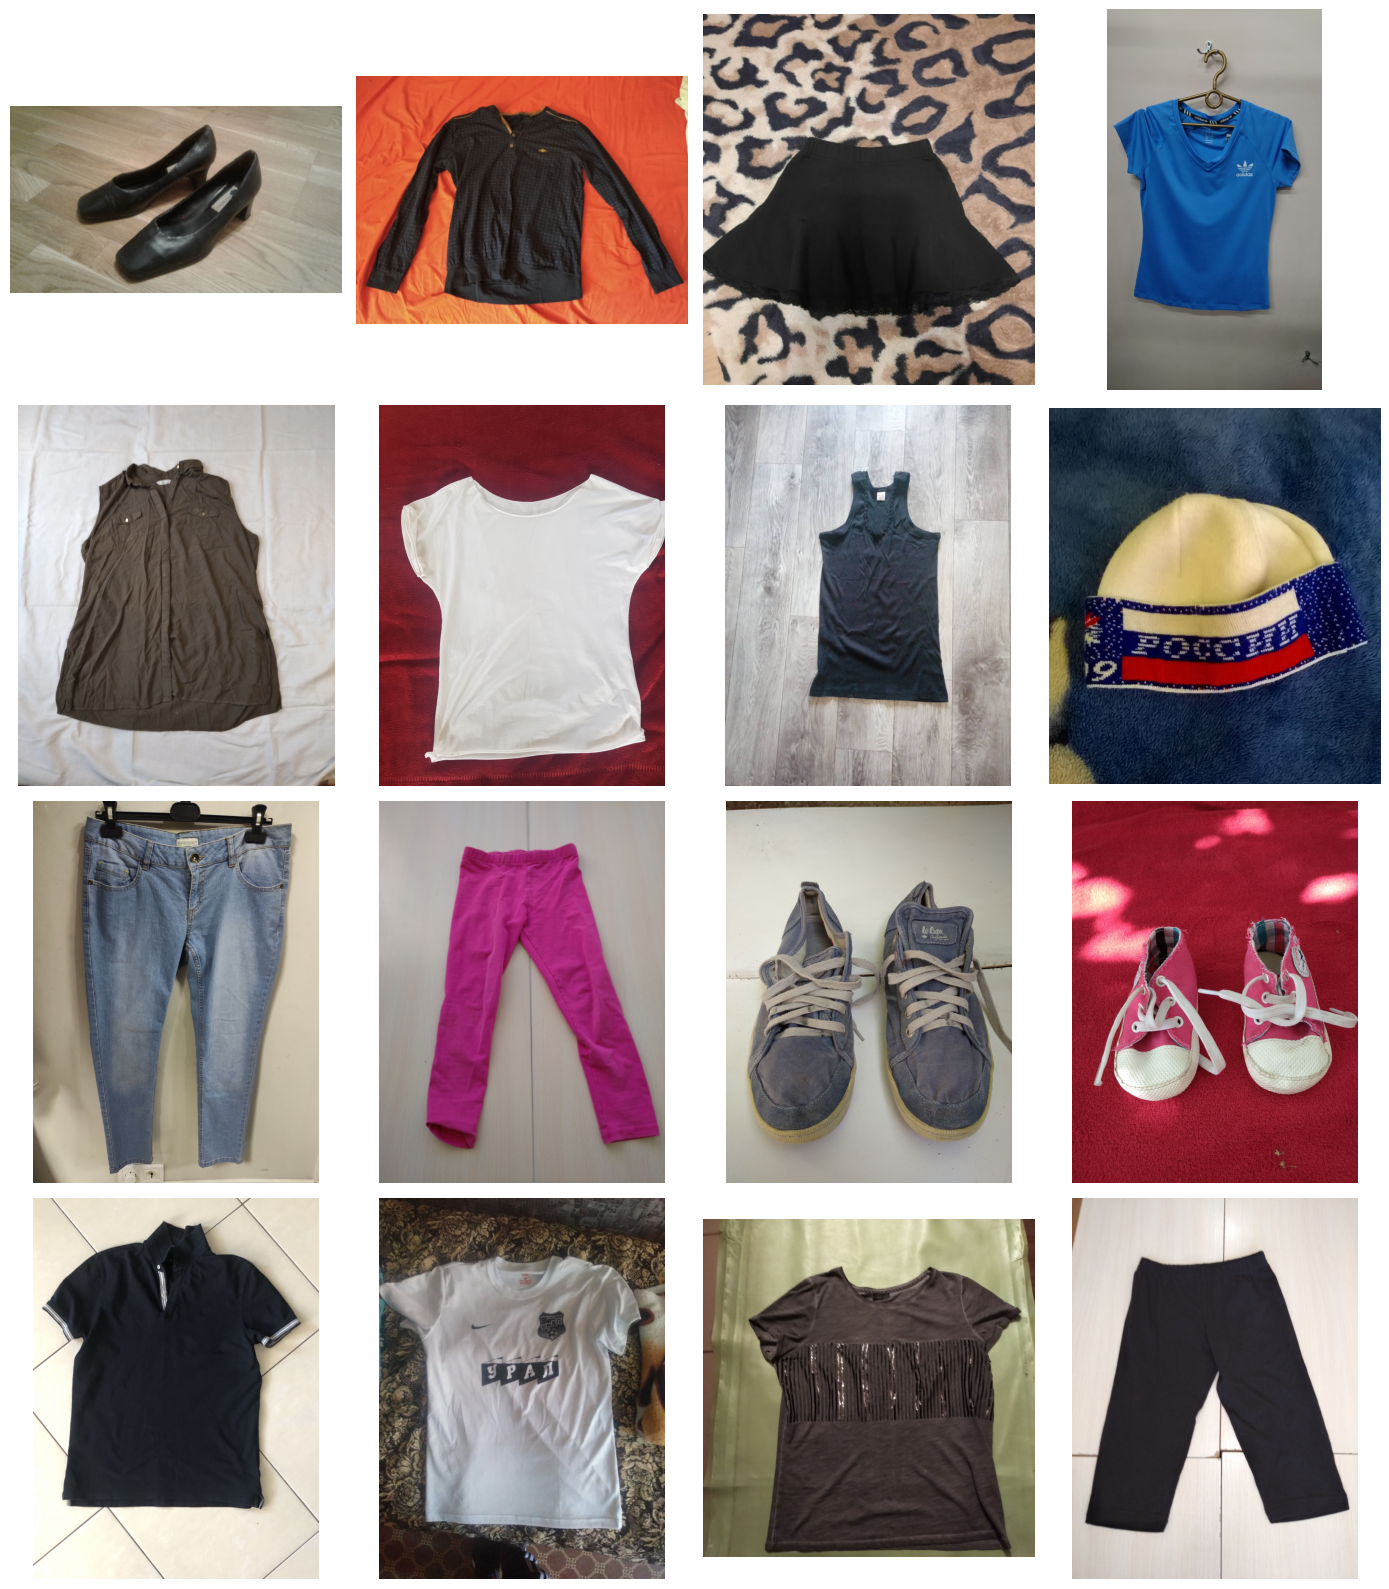

In [7]:
dataset_path = "/home/cat/projects/CV-stuff/background_remover/datasets/clothing-dataset-full"
object_dir = dataset_path + "/images_original"
img_names = os.listdir(object_dir)
print(len(img_names))
imgs = []

nrow, ncol = 4, 4

fig, axes = plt.subplots(nrow, ncol, figsize=(14, 16))
for i in range(nrow*ncol):
    rand = random.random()
    ax = axes[int(i/ncol), int(i%ncol)]
    name = random.choice(img_names)
    path = osp.join(object_dir, name)
    img = get_image(path)
    if rand > 0.5:
        print(img.shape)
    imgs.append(img)
    ax.imshow(img)
    ax.axis("off")
plt.tight_layout()

In [8]:
# %%writefile /kaggle/working/TRACER/config.py
import argparse

def getConfig(args_str):
    parser = argparse.ArgumentParser()
    parser.add_argument('action', type=str, default='train', help='Model Training or Testing options')
    parser.add_argument('--exp_num', default=0, type=str, help='experiment_number')
    parser.add_argument('--dataset', type=str, default='DUTS', help='DUTS')
    parser.add_argument('--data_path', type=str, default='data/')
    parser.add_argument('--save_path', type=str, default='results/')

    # Model parameter settings
    parser.add_argument('--arch', type=str, default='0', help='Backbone Architecture')
    parser.add_argument('--channels', type=list, default=[24, 40, 112, 320])
    parser.add_argument('--RFB_aggregated_channel', type=int, nargs='*', default=[32, 64, 128])
    parser.add_argument('--frequency_radius', type=int, default=16, help='Frequency radius r in FFT')
    parser.add_argument('--denoise', type=float, default=0.93, help='Denoising background ratio')
    parser.add_argument('--gamma', type=float, default=0.1, help='Confidence ratio')

    # Training parameter settings
    parser.add_argument('--img_size', type=int, default=320)
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--epochs', type=int, default=100)
    parser.add_argument('--lr', type=float, default=5e-5)
    parser.add_argument('--optimizer', type=str, default='Adam')
    parser.add_argument('--weight_decay', type=float, default=1e-4)
    parser.add_argument('--criterion', type=str, default='API', help='API or bce')
    parser.add_argument('--scheduler', type=str, default='Reduce', help='Reduce or Step')
    parser.add_argument('--aug_ver', type=int, default=2, help='1=Normal, 2=Hard')
    parser.add_argument('--lr_factor', type=float, default=0.1)
    parser.add_argument('--clipping', type=float, default=2, help='Gradient clipping')
    parser.add_argument('--patience', type=int, default=5, help="Scheduler ReduceLROnPlateau's parameter & Early Stopping(+5)")
    parser.add_argument('--model_path', type=str, default='results/')
    parser.add_argument('--seed', type=int, default=42)
    parser.add_argument('--save_map', type=bool, default=None, help='Save prediction map')


    # Hardware settings
    parser.add_argument('--multi_gpu', type=bool, default=True)
    parser.add_argument('--num_workers', type=int, default=4)
    cfg = parser.parse_args(args_str)

    return cfg

In [9]:
# change path to convert all images

args = getConfig("inference \
                 --data_path /home/cat/projects/CV-stuff/background_remover/datasets \
                 --dataset clothing-dataset-full/images_original \
                 --batch_size 8 \
                 --save_map True \
                 --arch 7 \
                 --img_size 640 \
                 --save_path /home/cat/projects/CV-stuff/background_remover/datasets/clothing-dataset-full/results".split())
args

Namespace(action='inference', exp_num=0, dataset='clothing-dataset-full/images_original', data_path='/home/cat/projects/CV-stuff/background_remover/datasets', save_path='/home/cat/projects/CV-stuff/background_remover/datasets/clothing-dataset-full/results', arch='7', channels=[24, 40, 112, 320], RFB_aggregated_channel=[32, 64, 128], frequency_radius=16, denoise=0.93, gamma=0.1, img_size=640, batch_size=8, epochs=100, lr=5e-05, optimizer='Adam', weight_decay=0.0001, criterion='API', scheduler='Reduce', aug_ver=2, lr_factor=0.1, clipping=2, patience=5, model_path='results/', seed=42, save_map=True, multi_gpu=True, num_workers=4)

In [10]:
class Inference():
    def __init__(self, args):
        super(Inference, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.test_transform = get_test_augmentation(img_size=args.img_size)
        self.args = args
        self.save_path = args.save_path

        # Network
        self.model = TRACER(args).to(self.device)
        if args.multi_gpu:
            self.model = nn.DataParallel(self.model).to(self.device)

        path = load_pretrained(f'TE-{args.arch}')
        self.model.load_state_dict(path)
        print('###### pre-trained Model restored #####')

        te_img_folder = os.path.join(args.data_path, args.dataset)
        te_gt_folder = None

        self.test_loader = get_loader(te_img_folder, te_gt_folder, edge_folder=None, phase='test',
                                      batch_size=args.batch_size, shuffle=False,
                                      num_workers=args.num_workers, transform=self.test_transform)

        if args.save_map:
            os.makedirs(os.path.join(self.save_path, 'mask'), exist_ok=True)
            os.makedirs(os.path.join(self.save_path, 'object'), exist_ok=True)
            os.makedirs(os.path.join(self.save_path, 'image'), exist_ok=True)

    def test(self):
        self.model.eval()
        t = time.time()

        with torch.no_grad():
            for i, (images, original_size, image_name) in enumerate(tqdm(self.test_loader)):
                images = torch.tensor(images, device=self.device, dtype=torch.float32)

                outputs, edge_mask, ds_map = self.model(images)
                H, W = original_size

                for i in range(images.size(0)):
                    h, w = H[i].item(), W[i].item()
                    output = F.interpolate(outputs[i].unsqueeze(0), size=(h, w), mode='bilinear')

                    # Save prediction map
                    if args.save_map:
                        output = (output.squeeze().detach().cpu().numpy() * 255.0).astype(np.uint8)

                        salient_object = self.post_processing(images[i], output, h, w)
                        cv2.imwrite(os.path.join(self.save_path, 'mask', image_name[i] + '.png'), output)
                        cv2.imwrite(os.path.join(self.save_path, 'object', image_name[i] + '.png'), salient_object)
                        # cv2.imwrite(os.path.join(self.save_path, 'image', image_name[i] + '.png'), images[i])

        print(f'time: {time.time() - t:.3f}s')
        
    def test_one_image(self, original_size, image):
        self.model.eval()
        t = time.time()

        with torch.no_grad():
            org_image = self.test_transform(image=image)["image"]
            image = org_image[None, ...]
#             image = torch.tensor(image, device=self.device, dtype=torch.float32)
            image = image.type(torch.float32)
            image.to(self.device)

            output, edge_mask, ds_map = self.model(image)
            h, w = original_size

            output = F.interpolate(output, size=(h, w), mode='bilinear')
            output = (output.squeeze().detach().cpu().numpy() * 255.0).astype(np.uint8)
            salient_object = self.post_processing(org_image, output, h, w)
            # Save prediction map
            if args.save_map:
                cv2.imwrite(os.path.join(self.save_path, 'mask', 'test.png'), output)
                cv2.imwrite(os.path.join(self.save_path, 'object', 'test.png'), salient_object)

        print(f'time: {time.time() - t:.3f}s')
        return output, salient_object

    def post_processing(self, original_image, output_image, height, width, threshold=200):
        invTrans = transforms.Compose([transforms.Normalize(mean=[0., 0., 0.],
                                                            std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
                                       transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                                            std=[1., 1., 1.]),
                                       ])
        original_image = invTrans(original_image)

        original_image = F.interpolate(original_image.unsqueeze(0), size=(height, width), mode='bilinear')
        original_image = (original_image.squeeze().permute(1, 2, 0).detach().cpu().numpy() * 255.0).astype(np.uint8)

        rgba_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2BGRA)
        output_rbga_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2BGRA)

        output_rbga_image[:, :, 3] = output_image  # Extract edges
        edge_y, edge_x, _ = np.where(output_rbga_image <= threshold)  # Edge coordinates

        # removes background
        # rgba_image[edge_y, edge_x, 3] = 0
        return cv2.cvtColor(rgba_image, cv2.COLOR_RGBA2BGRA)

In [11]:
import torch.version


torch.cuda.is_available()
# torch.__version__
# !nvidia-smi

True

In [12]:
model = Inference(args)

/home/cat/projects/CV-stuff/background_remover/TRACER/dataloader.py:132: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  albu.Resize(img_size, img_size, always_apply=True),


Loaded pretrained weights for efficientnet-b7
###### pre-trained Model restored #####
test length : 5762


In [13]:
model.test()

  0%|          | 0/721 [00:00<?, ?it/s]/tmp/ipykernel_151340/2375146133.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, device=self.device, dtype=torch.float32)
 91%|█████████▏| 658/721 [1:32:22<08:50,  8.42s/it]

: 

In [39]:
img = random.choice(imgs)
img = cv2.resize(img, (768, 1024))
print(img.shape)
mask, object_img = model.test_one_image(img.shape[:2], img)

(1024, 768, 3)
time: 0.278s


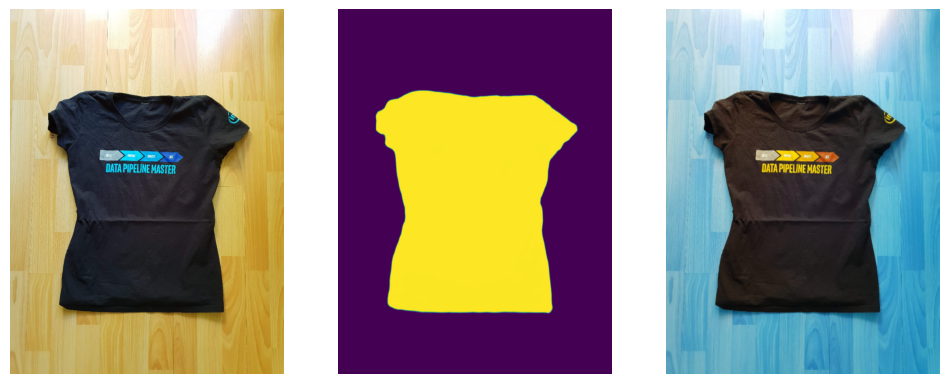

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(12, 16))

for i, image in enumerate([img, mask, object_img]):
    axes[i].imshow(image)
    axes[i].axis("off")

In [41]:
img_samples = random.sample(imgs, 4)
imgs = []
outputs = []

for img in img_samples:
    img = cv2.resize(img, (768, 1024))
    imgs.append(img)
    outputs.append(model.test_one_image(img.shape[:2], img))

time: 0.282s
time: 0.283s
time: 0.272s
time: 0.266s


In [42]:
len(list(zip(*outputs)))

2

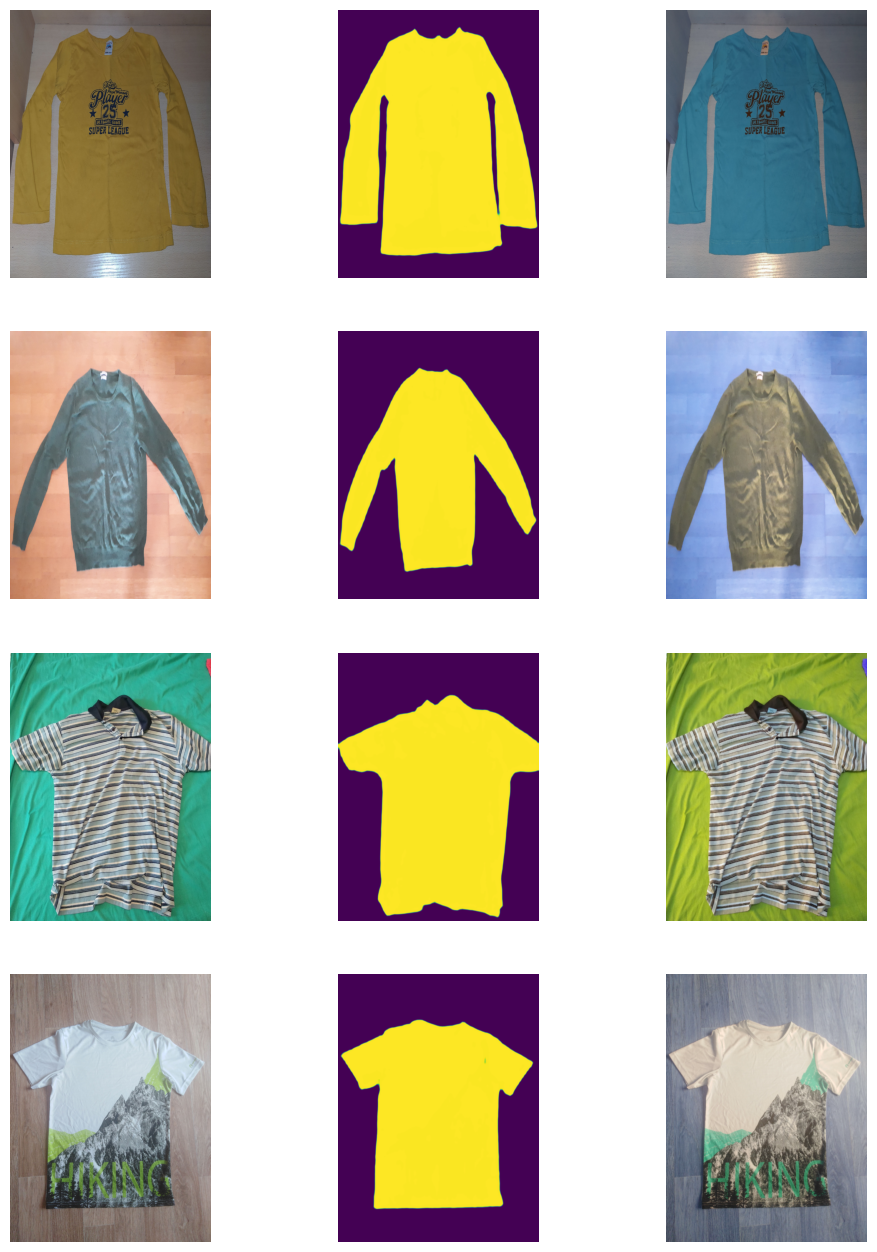

In [43]:
fig, axes = plt.subplots(4, 3, figsize=(12, 16))

for i, img_pairs in enumerate(zip(imgs, *list(zip(*outputs)))):
    for idx, img in enumerate(img_pairs):
        axes[i, idx].imshow(img)
        axes[i, idx].axis("off")